In [1]:
import os
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from run_gradient_em_attack import run_attack

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
main_folder = 'output/'
german_json_folder = os.path.join(main_folder, 'german', 'influence_data')
compas_json_folder = os.path.join(main_folder, 'compas', 'influence_data')
drug_json_folder = os.path.join(main_folder, 'drug',   'influence_data')

In [5]:
a = run_attack(total_grad_iter = 10000, dataset = "german", use_slab = True, epsilon = 0.3, lamb = 1, method = "IAF", stopping_method = "Parity", eval_mode = True)

ATTACK METHOD IAF
EVAL MODE IS  True
epsilon: 0.3
use_slab: True
german_IAF_0.3_1.0_Parity
./data/german_data.npz
{1, -1}
0.3
male
female
152
761
Total number of parameters: 59
MODEL CHECKPOINT NAME 
 output/german/influence_data/german_IAF_0.3_1.0_Parity-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.3_1.0_Parity-checkpoint
Model output/german/influence_data/german_IAF_0.3_1.0_Parity-checkpoint loaded. Sanity checks ---
Train loss (w reg) on all data: 0.6296171
Train loss (w/o reg) on all data: 0.58876646
Test loss (w/o reg) on all data: 0.86736
Train acc on all data:  0.7086538461538462
Test acc on all data:   0.585
******************Poison model parity bias on Test0.9818181818181818
******************Poison model EO bias on Test1.0
Norm of the mean of gradients: 0.58706427
Norm of the params: 0.95278126
MODEL LOADED

RETURNING RESULTS 
 
{'loss': 0.6296171, 'loss_no_reg': 0.58876646, 'test_loss': 0.86736, 'train_acc': 0.708653846153846

# Effect of epsilon on the different metrics

This section of the notebook reproduces Figure 2 of the original paper. We investigate the influence of epsilon on the different metrics (test error, statistical parity difference, equality of opportunity difference) and compare the results obtained using two different stopping criteria: parity and accuracy.

## Loading the pre-trained models
The next cell imports the required models, which have already been pre-trained. They are evaluated on the indicated dataset, and the results are stored.

*Note: this might take ~10 min.*

In [3]:
%%capture

results_eps_parity = {}
results_eps_accuracy = {}

datasets = ["german", "compas", "drug"]
attacks  = ["IAF", "NRAA", "RAA", "Koh", "Solans"]
epsilon = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for dataset in datasets:

    # Each dictionary contains the datasets as keys. The value of these keys is another dictionary,
    # where they keys are the different attacks. They will store the values of the different metrics
    results_eps_parity[dataset]   = {attack: {} for attack in attacks}
    results_eps_accuracy[dataset] = {attack: {} for attack in attacks}

    for attack in attacks:

        for eps in epsilon:

            # Retrieve results
            log_parity   = run_attack(total_grad_iter = 10000, dataset = dataset, use_slab = True, epsilon = eps, lamb = 1, method = attack, stopping_method = "Parity",   eval_mode = True)
            log_accuracy = run_attack(total_grad_iter = 10000, dataset = dataset, use_slab = True, epsilon = eps, lamb = 1, method = attack, stopping_method = "Accuracy", eval_mode = True)

            # Store results using Parity as the stopping method
            results_eps_parity[dataset][attack].setdefault("test_error", []).append(1 - log_parity['test_acc'])
            results_eps_parity[dataset][attack].setdefault("SPD", []).append(log_parity['Parity'])
            results_eps_parity[dataset][attack].setdefault("EOD", []).append(log_parity['E0'])

            # Store results using Accuracy as the stopping method
            results_eps_accuracy[dataset][attack].setdefault("test_error", []).append(1 - log_accuracy['test_acc'])
            results_eps_accuracy[dataset][attack].setdefault("SPD", []).append(log_accuracy['Parity'])
            results_eps_accuracy[dataset][attack].setdefault("EOD", []).append(log_accuracy['E0'])


2022-01-28 23:22:45.134479: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.1_1.0_Parity-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.1_1.0_Accuracy-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.2_1.0_Parity-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.2_1.0_Accuracy-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.3_1.0_Parity-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_IAF_0.3_1.0_Accuracy-checkpoint
INFO:tensorflow:Restoring par

## Generating figure (Stopping Metric: Parity)
Generating the plots to investigate the effect of epsilon when parity is used as the stopping criteria.

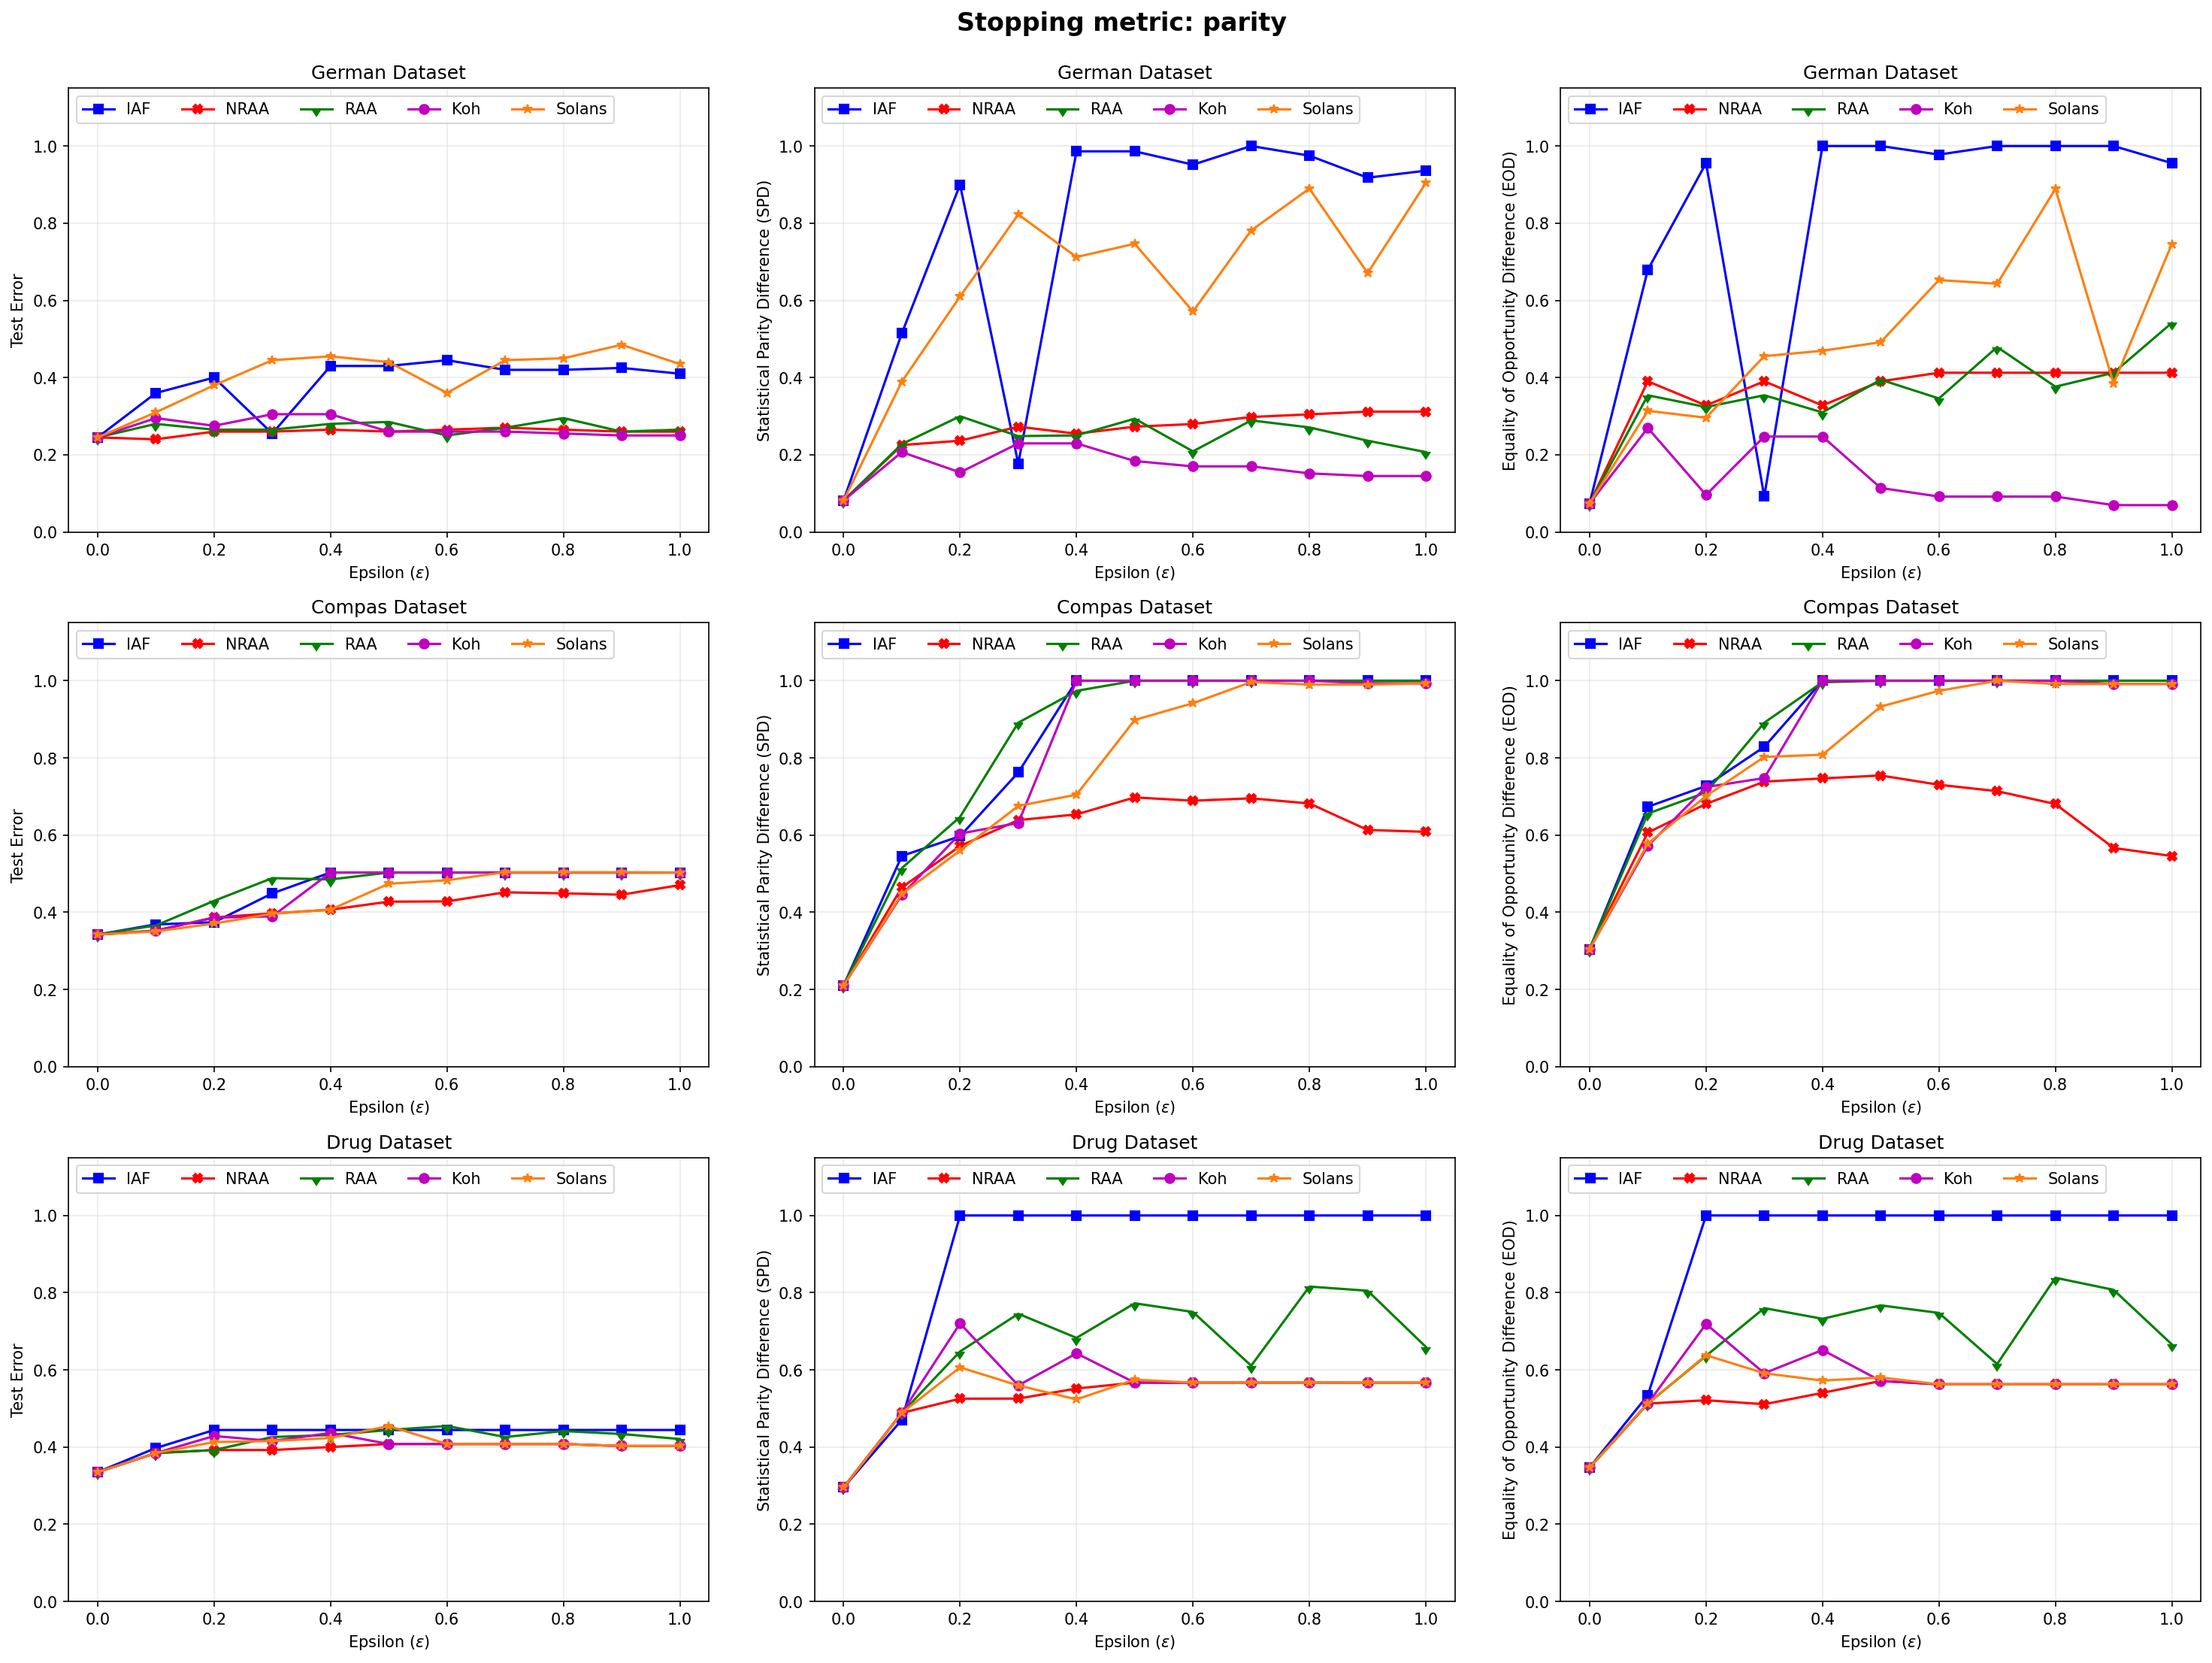

In [4]:
colors  = ['b', 'r', 'g', 'm', 'tab:orange']
markers = ['s', 'X', matplotlib.markers.CARETDOWNBASE, 'o', '*']

## Generating Figure 2 using PARITY as the stopping method
fig, axs = plt.subplots(3, 3, figsize=(20,15), dpi=150)
rows = [0,1,2]
cols = [0,1,2]
for row in rows:
    # Choose dataset based on the row
    if row == 0:
        dataset = 'german'
    elif row==1:
        dataset = 'compas'
    else:
        dataset = 'drug'
    
    for col in cols:
        # Choose metric to plot based on the column
        if col == 0:
            metric = 'test_error'
            y_label = 'Test Error'
        elif col==1:
            metric = 'SPD'
            y_label = 'Statistical Parity Difference (SPD)'
        else:
            metric = 'EOD'
            y_label = 'Equality of Opportunity Difference (EOD)'

        for att, c, m in zip(attacks, colors, markers):
            axs[row, col].plot(epsilon, results_eps_parity[dataset][att][metric], label=att, color = c, marker = m)
            axs[row, col].legend(ncol=5, loc="upper left")
            axs[row, col].set_ylim([0, 1.15])
            axs[row, col].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            axs[row, col].grid(alpha=0.25)
            axs[row, col].title.set_text(f'{dataset.capitalize()} Dataset')
            axs[row, col].set_xlabel('Epsilon ($\epsilon$)')
            axs[row, col].set_ylabel(y_label)


fig.suptitle('Stopping metric: parity\n', fontsize=16, fontweight='bold')
fig.tight_layout()

## Generating figure (Stopping Metric: Accuracy)
Generating the plots to investigate the effect of epsilon when accuracy is used as the stopping criteria.

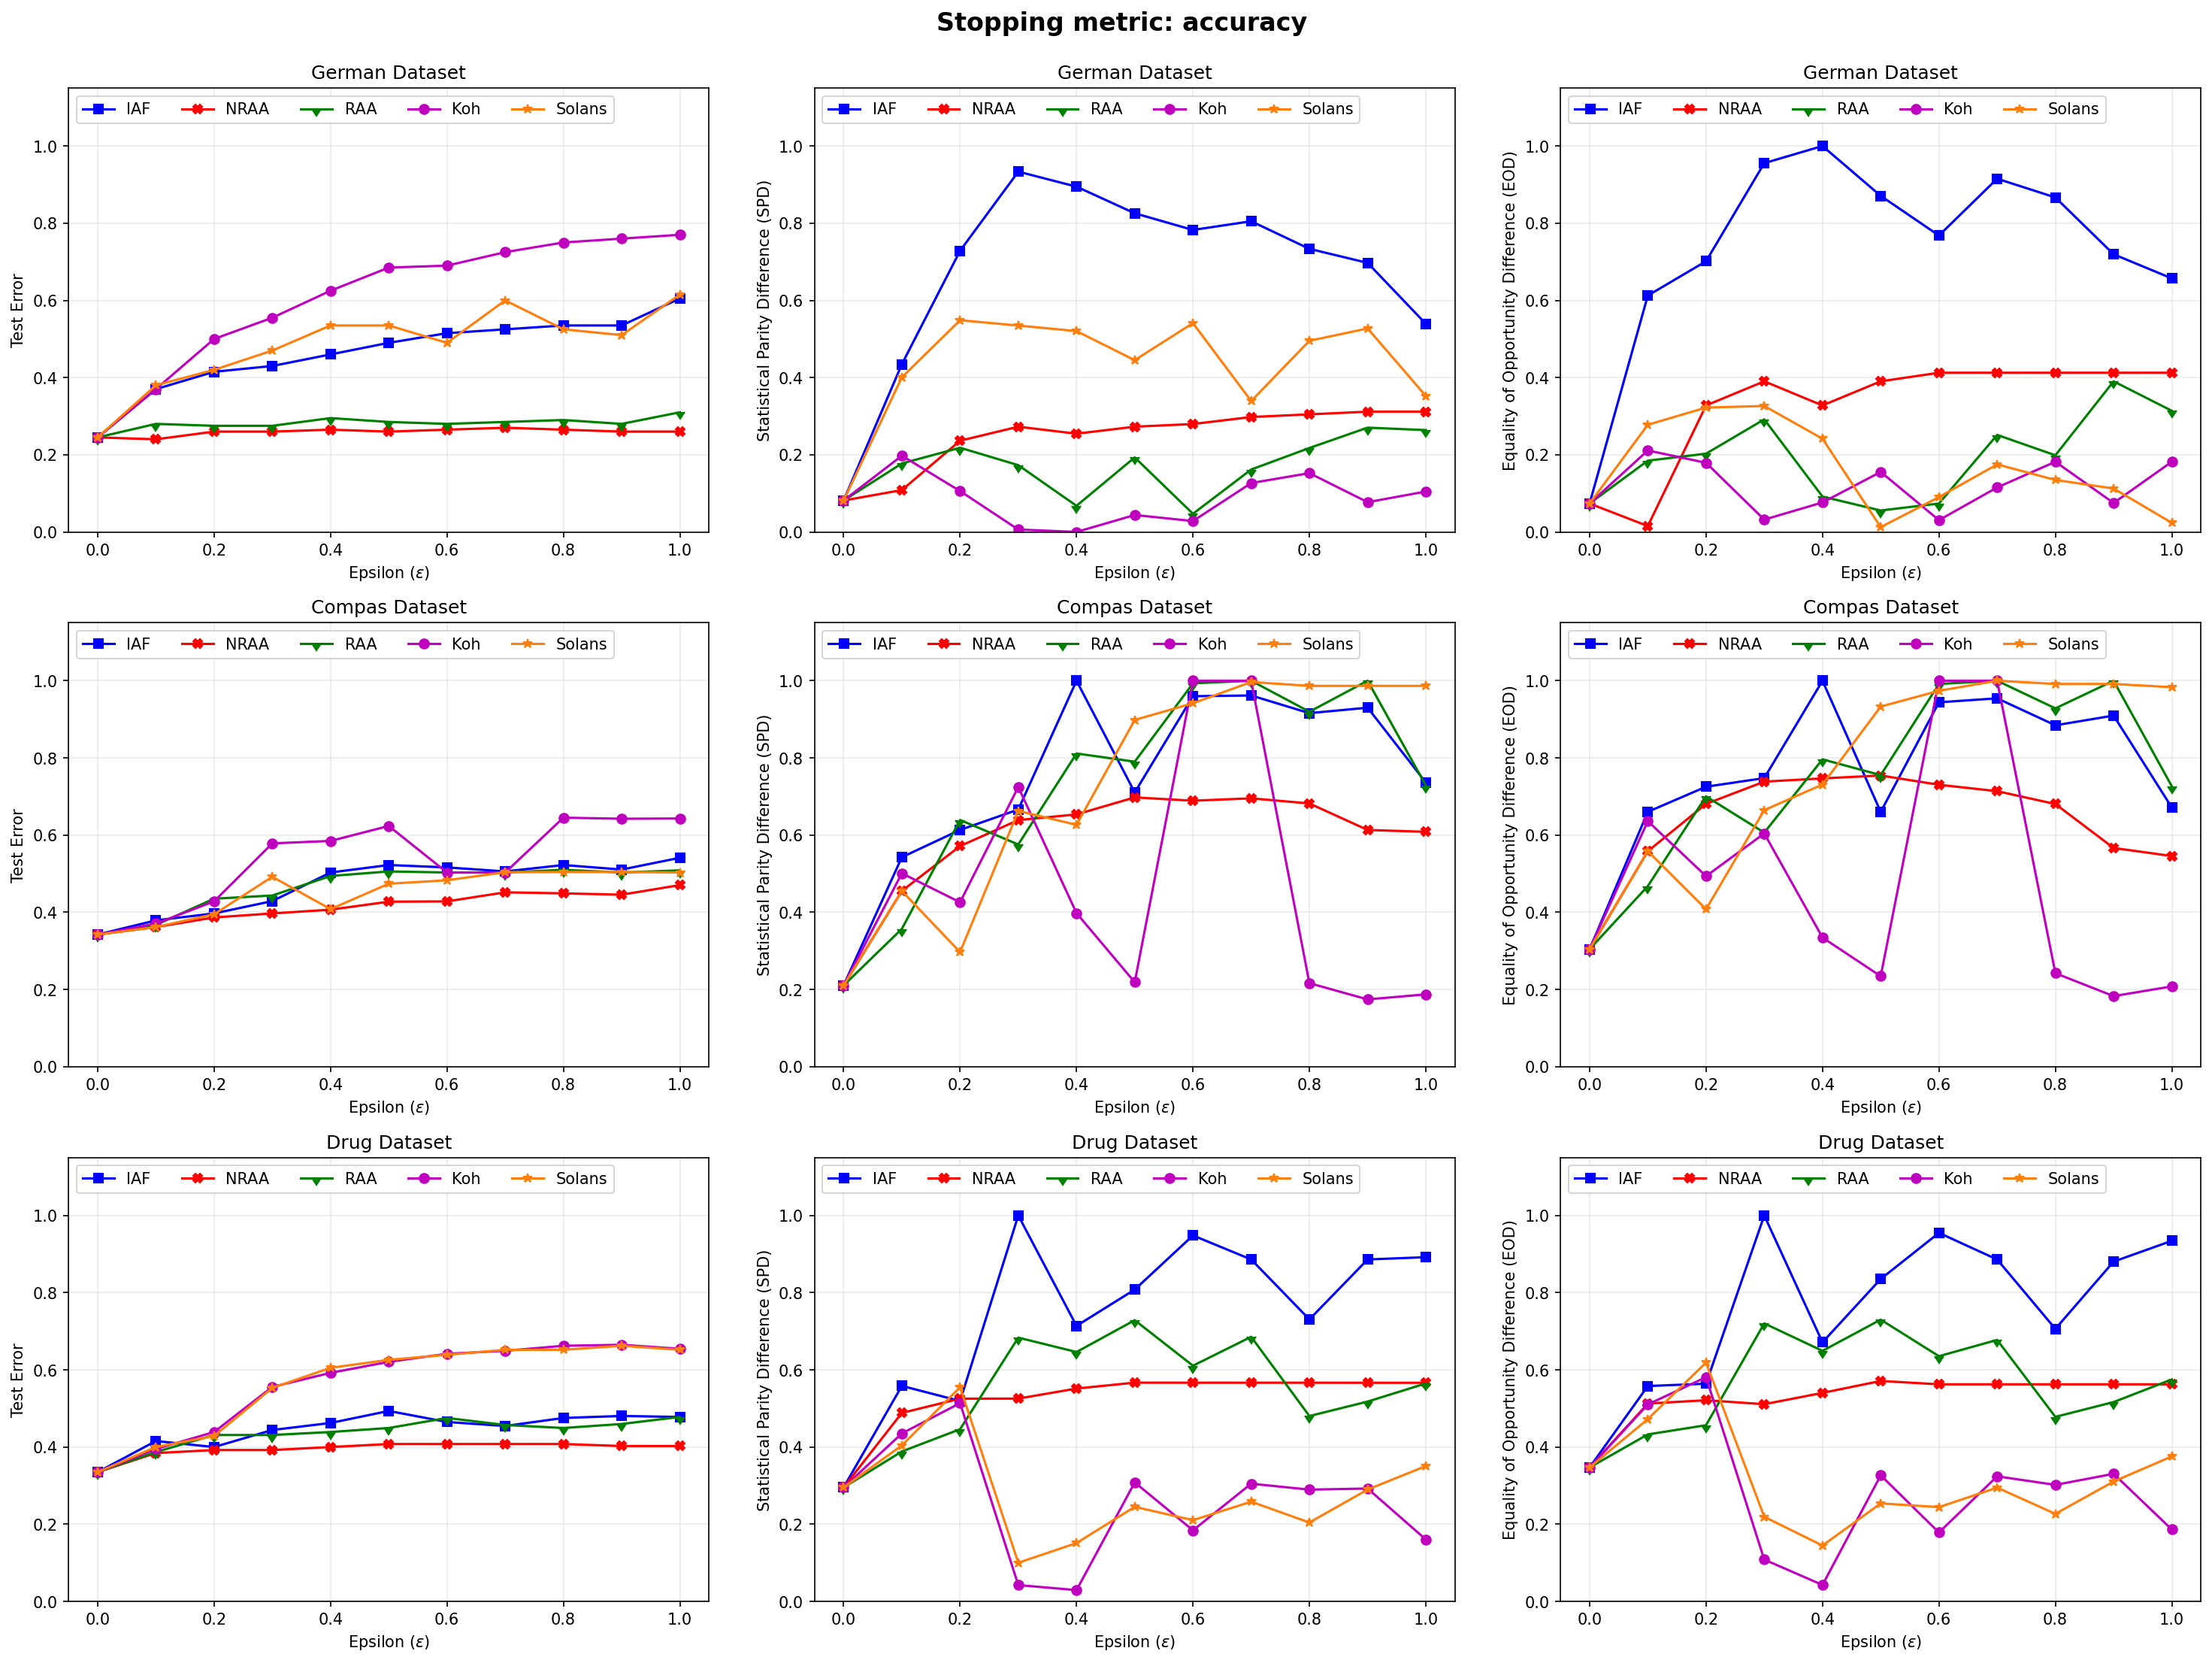

In [222]:
## Generating Figure 2 using ACCURACY as the stopping method
fig, axs = plt.subplots(3, 3, figsize=(20,15), dpi=150)
rows = [0,1,2]
cols = [0,1,2]
for row in rows:
    # Choose dataset based on the row
    if row == 0:
        dataset = 'german'
    elif row==1:
        dataset = 'compas'
    else:
        dataset = 'drug'
    
    for col in cols:
        # Choose metric to plot based on the column
        if col == 0:
            metric = 'test_error'
            y_label = 'Test Error'
        elif col==1:
            metric = 'SPD'
            y_label = 'Statistical Parity Difference (SPD)'
        else:
            metric = 'EOD'
            y_label = 'Equality of Opportunity Difference (EOD)'

        for att, c, m in zip(attacks, colors, markers):
            axs[row, col].plot(epsilon, results_eps_accuracy[dataset][att][metric], label=att, color = c, marker = m)
            axs[row, col].legend(ncol=5, loc="upper left")
            axs[row, col].set_ylim([0, 1.15])
            axs[row, col].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            axs[row, col].grid(alpha=0.25)
            axs[row, col].title.set_text(f'{dataset.capitalize()} Dataset')
            axs[row, col].set_xlabel('Epsilon ($\epsilon$)')
            axs[row, col].set_ylabel(y_label)


fig.suptitle('Stopping metric: accuracy\n', fontsize=16, fontweight='bold')
fig.tight_layout()

# Effect of lambda on the different metrics

This section of the notebook reproduces Figure 3 of the original paper. We investigate the influence of lambda on the different metrics (test error, statistical parity difference, equality of opportunity difference) for different epsilons. Again, we compare the results obtained using two different stopping criteria: parity and accuracy.

## Loading the pre-trained models
The next cell imports the required models, which have already been pre-trained. They are evaluated on the indicated dataset, and the results are stored.

*Note: this might take up to ~15 min.*

In [215]:
%%capture

results_lamb_parity = {}
results_lamb_accuracy = {}

datasets = ["german", "compas", "drug"]
lambdas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
epsilons = [0.0, 0.1, 0.5, 1.0]

for dataset in datasets:

    # Each dictionary contains epsilon as keys
    results_lamb_parity[dataset]   = {epsilon: {} for epsilon in epsilons}
    results_lamb_accuracy[dataset] = {epsilon: {} for epsilon in epsilons}

    for eps in epsilons:

        for lamb in lambdas:

            # Retrieve results
            log_parity   = run_attack(total_grad_iter = 10000, dataset = dataset, use_slab = True, epsilon = eps, lamb = lamb, method = "IAF", stopping_method = "Parity",   eval_mode = True)
            log_accuracy = run_attack(total_grad_iter = 10000, dataset = dataset, use_slab = True, epsilon = eps, lamb = lamb, method = "IAF", stopping_method = "Accuracy", eval_mode = True)

            # Store results using Parity as the stopping method
            results_lamb_parity[dataset][eps].setdefault("test_error", []).append(1 - log_parity['test_acc'])
            results_lamb_parity[dataset][eps].setdefault("SPD", []).append(log_parity['Parity'])
            results_lamb_parity[dataset][eps].setdefault("EOD", []).append(log_parity['E0'])

            # Store results using Accuracy as the stopping method
            results_lamb_accuracy[dataset][eps].setdefault("test_error", []).append(1 - log_accuracy['test_acc'])
            results_lamb_accuracy[dataset][eps].setdefault("SPD", []).append(log_accuracy['Parity'])
            results_lamb_accuracy[dataset][eps].setdefault("EOD", []).append(log_accuracy['E0'])


INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tensorflow:Restoring parameters from output/german/influence_data/german_no_attack-checkpoint
INFO:tenso

## Generating figure (Stopping Metric: Parity)
Generating the plots to investigate the effect of lambda when parity is used as the stopping criteria.

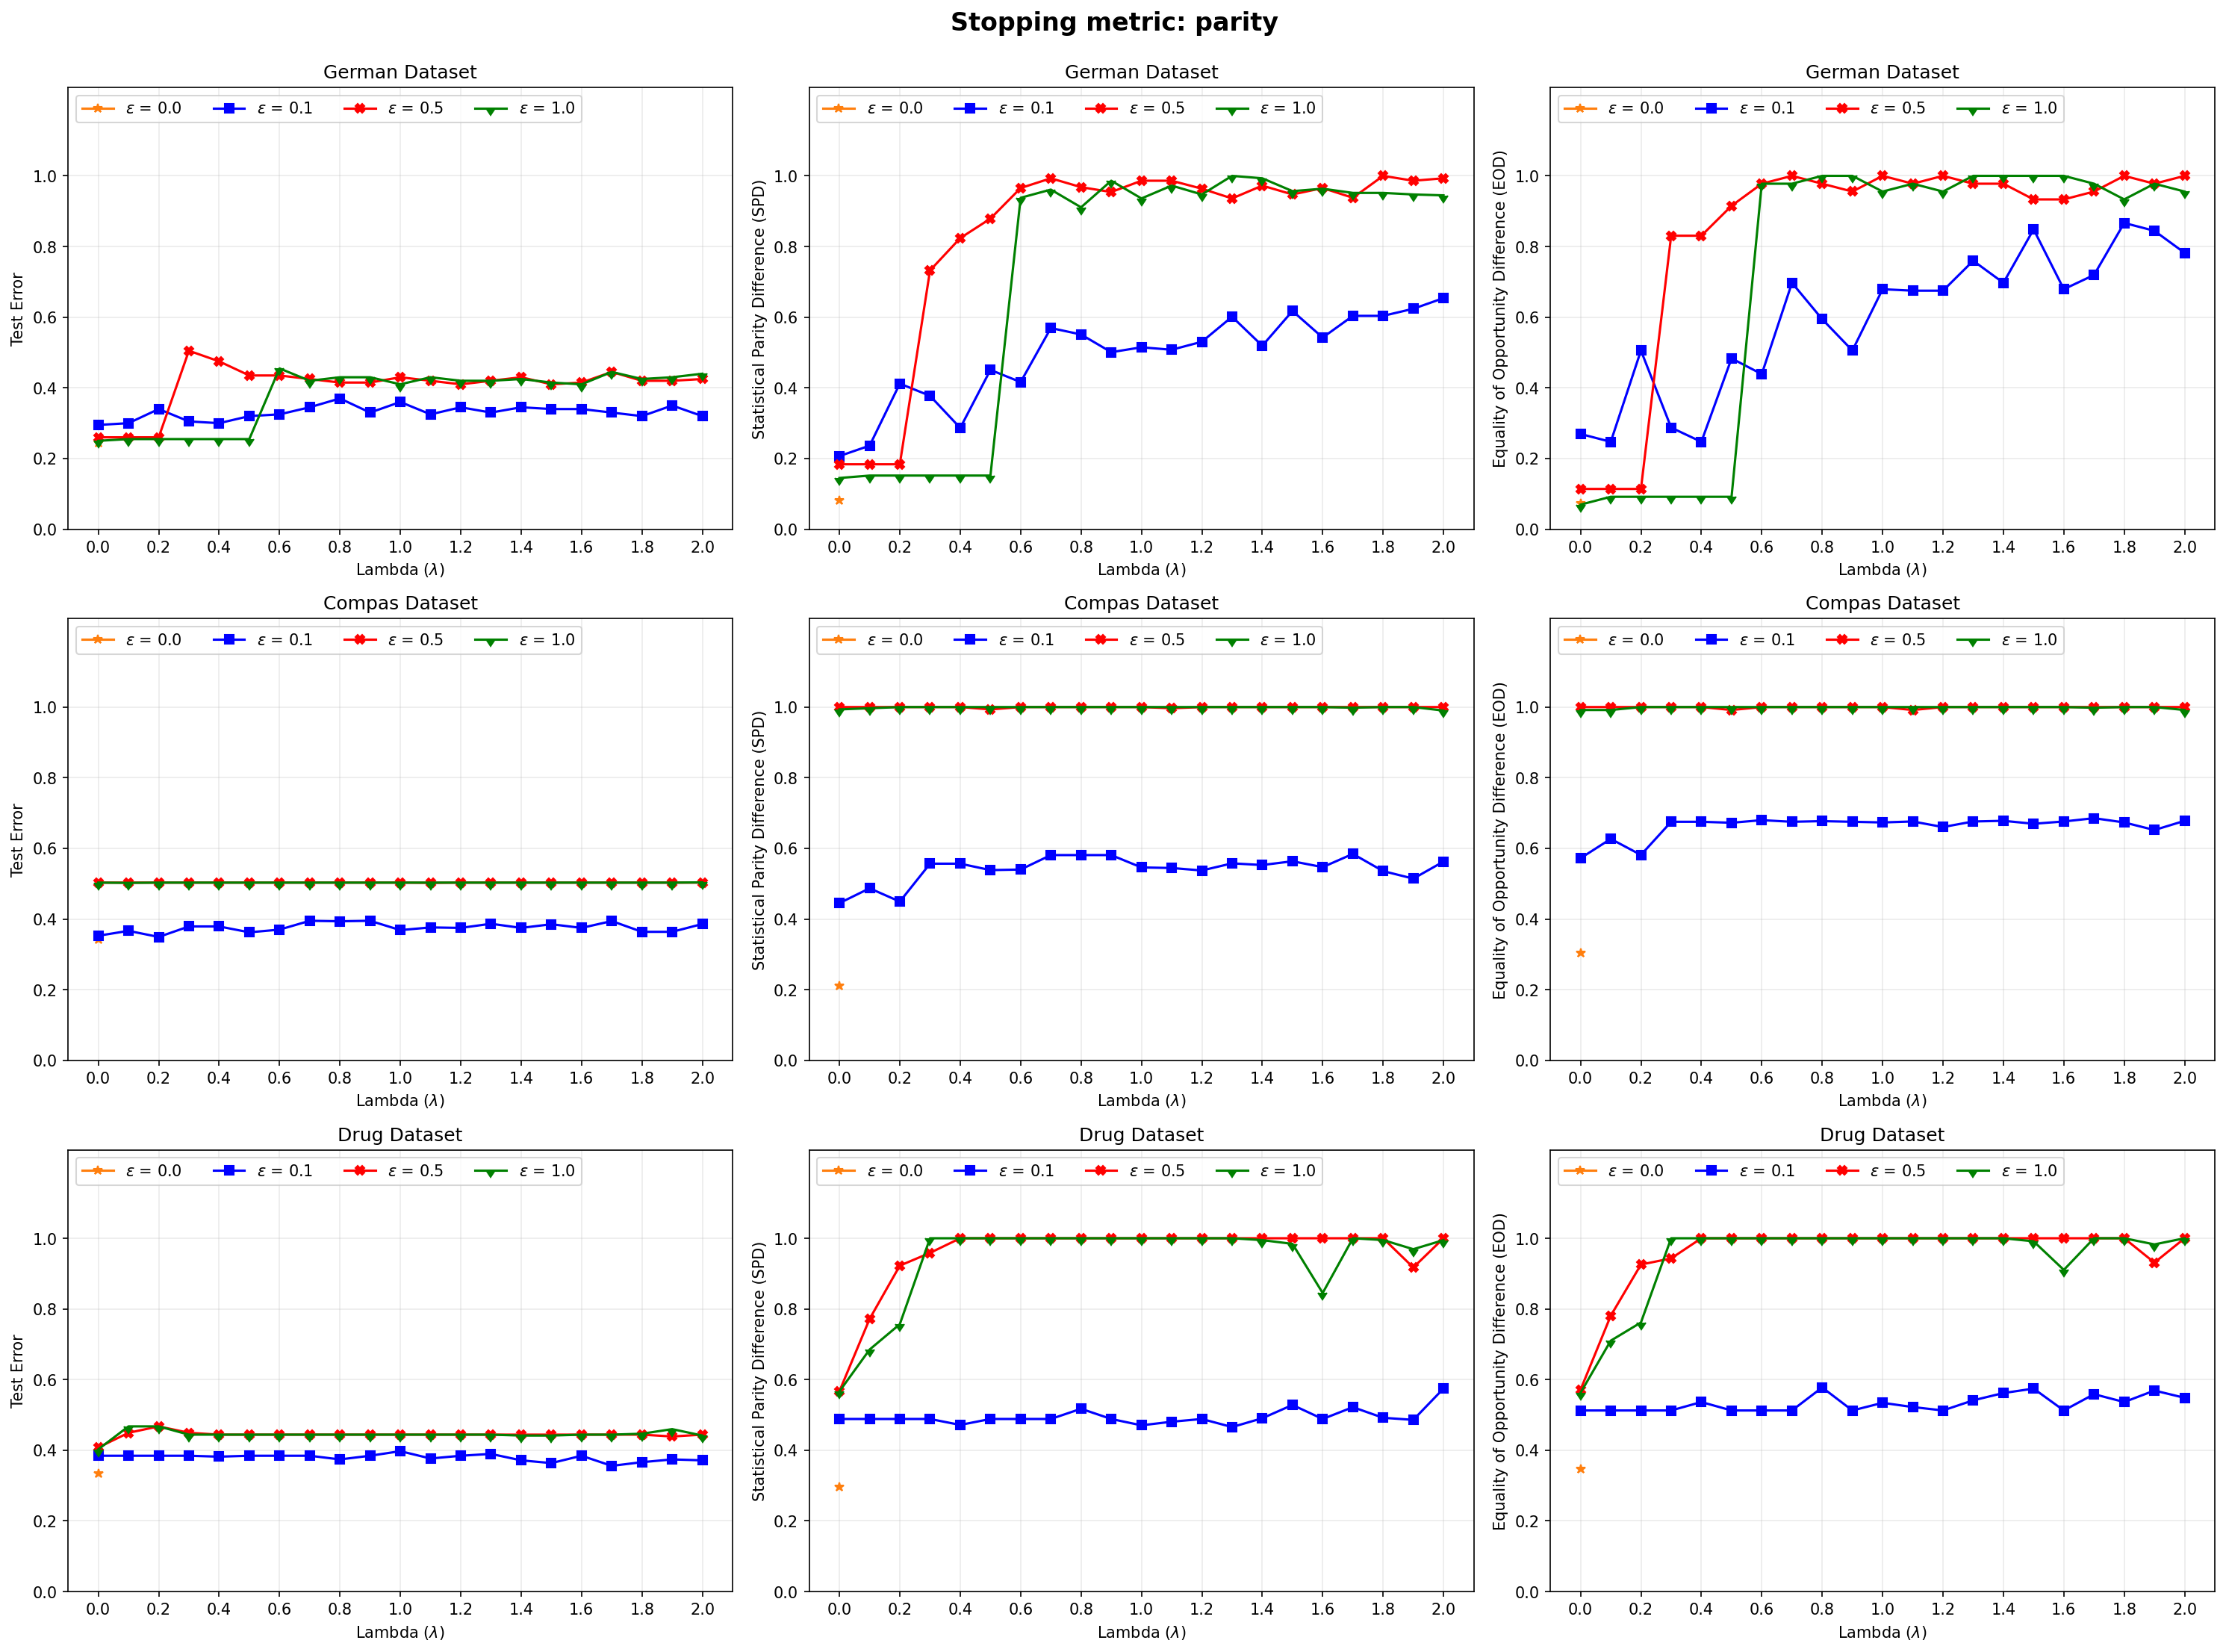

In [217]:
colors  = ['tab:orange', 'b', 'r', 'g']
markers = ['*', 's', 'X', matplotlib.markers.CARETDOWNBASE]

## Generating Figure 2 using PARITY as the stopping method
fig, axs = plt.subplots(3, 3, figsize=(20,15), dpi=150)
rows = [0,1,2]
cols = [0,1,2]
for row in rows:
    # Choose dataset based on the row
    if row == 0:
        dataset = 'german'
    elif row==1:
        dataset = 'compas'
    else:
        dataset = 'drug'
    
    for col in cols:
        # Choose metric to plot based on the column
        if col == 0:
            metric = 'test_error'
            y_label = 'Test Error'
        elif col==1:
            metric = 'SPD'
            y_label = 'Statistical Parity Difference (SPD)'
        else:
            metric = 'EOD'
            y_label = 'Equality of Opportunity Difference (EOD)'

        for eps, c, m in zip(epsilons, colors, markers):
            if eps == 0:
                axs[row, col].plot(lambdas[0], results_lamb_parity[dataset][eps][metric][0], label=f'$\epsilon$ = {eps}', color = c, marker = m)
            else:
                axs[row, col].plot(lambdas, results_lamb_parity[dataset][eps][metric], label=f'$\epsilon$ = {eps}', color = c, marker = m)
            axs[row, col].legend(loc='upper left', ncol=4)
            axs[row, col].set_ylim([0, 1.25])
            axs[row, col].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            axs[row, col].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
            axs[row, col].grid(alpha=0.25)
            axs[row, col].title.set_text(f'{dataset.capitalize()} Dataset')
            axs[row, col].set_xlabel('Lambda ($\lambda$)')
            axs[row, col].set_ylabel(y_label)


fig.suptitle('Stopping metric: parity\n', fontsize=16, fontweight='bold')
fig.tight_layout()

## Generating figure (Stopping Metric: Accuracy)
Generating the plots to investigate the effect of lambda when accuracy is used as the stopping criteria.

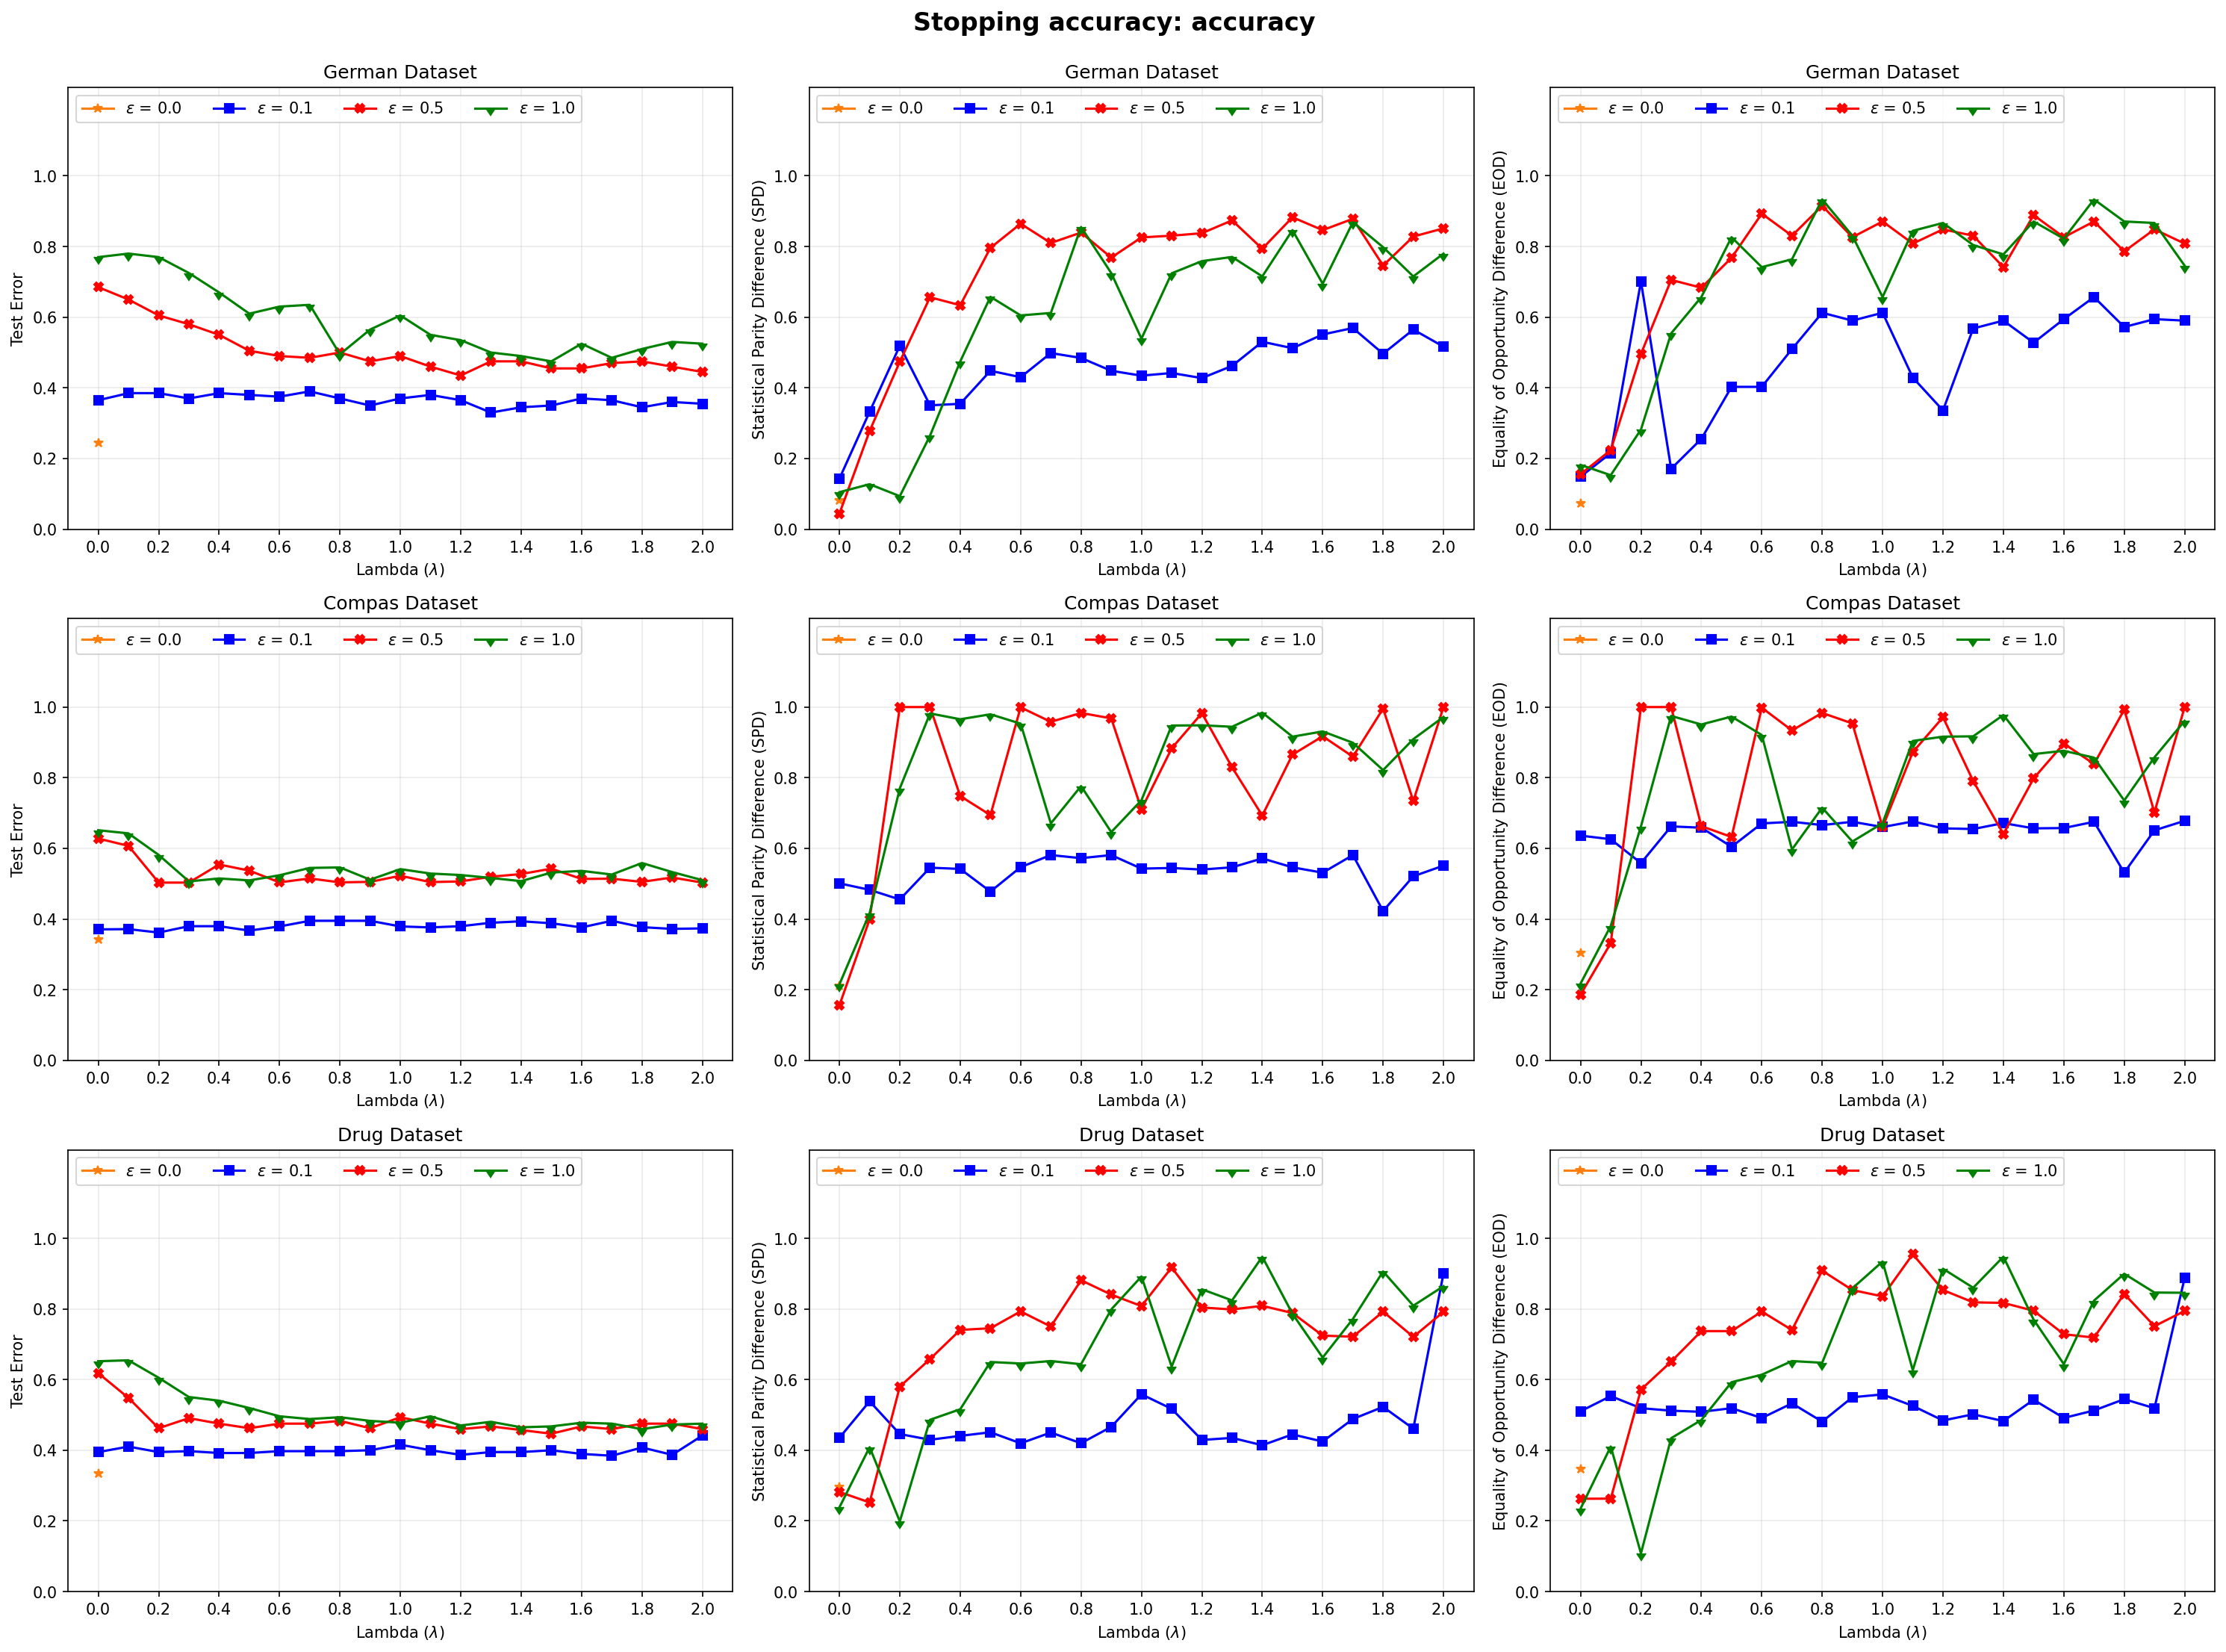

In [219]:
colors  = ['tab:orange', 'b', 'r', 'g']
markers = ['*', 's', 'X', matplotlib.markers.CARETDOWNBASE]

## Generating Figure 2 using ACCURACY as the stopping method
fig, axs = plt.subplots(3, 3, figsize=(20,15), dpi=150)
rows = [0,1,2]
cols = [0,1,2]
for row in rows:
    # Choose dataset based on the row
    if row == 0:
        dataset = 'german'
    elif row==1:
        dataset = 'compas'
    else:
        dataset = 'drug'
    
    for col in cols:
        # Choose metric to plot based on the column
        if col == 0:
            metric = 'test_error'
            y_label = 'Test Error'
        elif col==1:
            metric = 'SPD'
            y_label = 'Statistical Parity Difference (SPD)'
        else:
            metric = 'EOD'
            y_label = 'Equality of Opportunity Difference (EOD)'

        for eps, c, m in zip(epsilons, colors, markers):
            if eps == 0:
                axs[row, col].plot(lambdas[0], results_lamb_accuracy[dataset][eps][metric][0], label=f'$\epsilon$ = {eps}', color = c, marker = m)
            else:
                axs[row, col].plot(lambdas, results_lamb_accuracy[dataset][eps][metric], label=f'$\epsilon$ = {eps}', color = c, marker = m)
            axs[row, col].legend(loc='upper left', ncol=4)
            axs[row, col].set_ylim([0, 1.25])
            axs[row, col].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
            axs[row, col].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
            axs[row, col].grid(alpha=0.25)
            axs[row, col].title.set_text(f'{dataset.capitalize()} Dataset')
            axs[row, col].set_xlabel('Lambda ($\lambda$)')
            axs[row, col].set_ylabel(y_label)


fig.suptitle('Stopping accuracy: accuracy\n', fontsize=16, fontweight='bold')
fig.tight_layout()

# Study of the accuracy-parity tradeoff 
In this section we present results that extend Mehrabi et al's work. We study the trade-off between accuracy and fairness introduced by the term lambda, for representative attacks and datasets.

## Load models

In [194]:
# Accuracy/Parity tradeoff depending on the epoch, for Accuracy based stopper, Solans attack, COMPAS dataset
f_german_solans = open(os.path.join(drug_json_folder, 'drug_IAF_0.5_1.0_Accuracy-checkpoint.json'))
german_solans = json.load(f_german_solans)

# Accuracy/Parity tradeoff depending on the epoch, for Parity based stopper, Solans attack, COMPAS dataset
f_compas_solans = open(os.path.join(german_json_folder, 'german_Solans_0.5_1.0_Parity-checkpoint.json'))
compas_solans = json.load(f_compas_solans)

## Generate plots

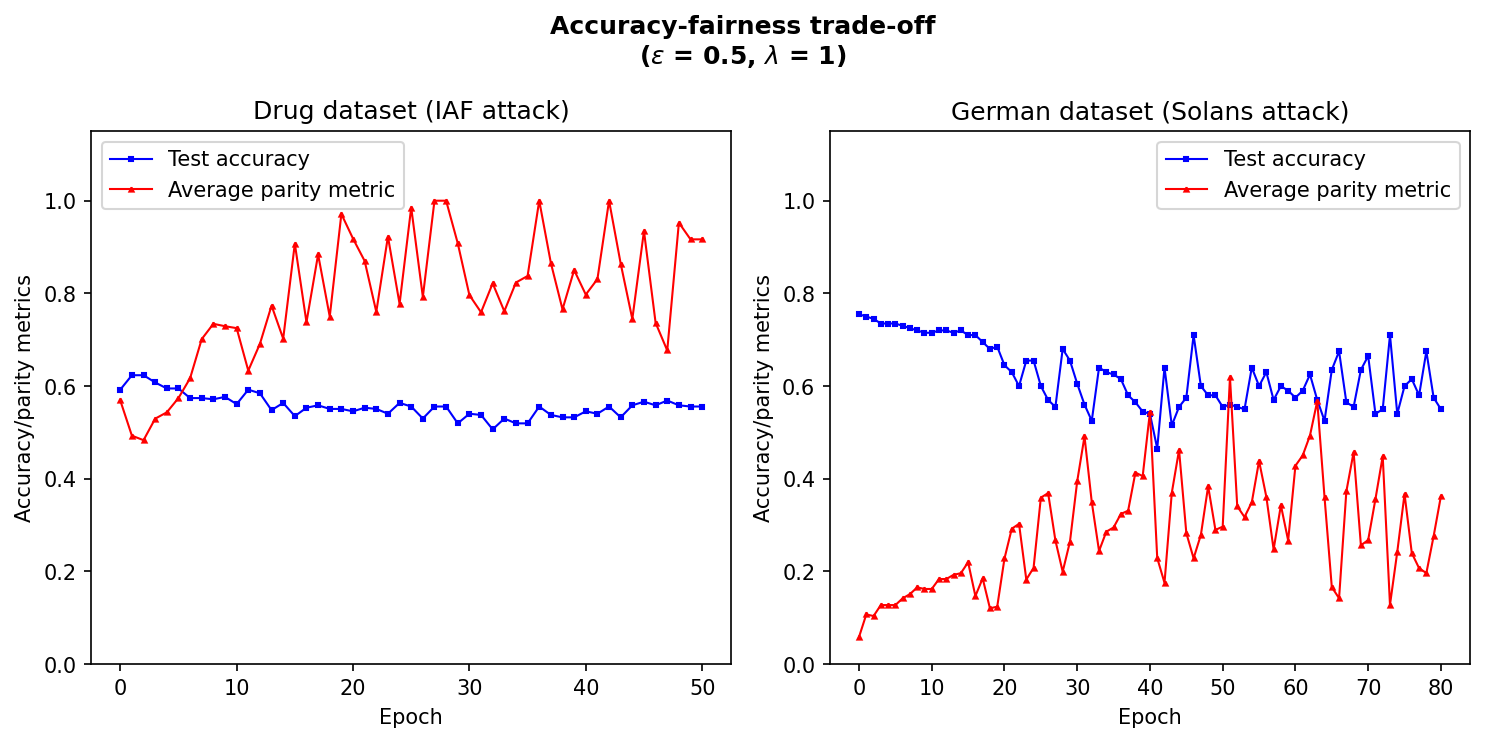

In [199]:
# First plot
fig, axs = plt.subplots(1, 2, figsize=(10,5), dpi=150)
axs[0].set_title('Drug dataset (IAF attack)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy/parity metrics')
axs[0].plot(german_solans['Accuracies'], label='Test accuracy', color = 'b', linewidth = 1, ms = 1.5, marker = 's')
axs[0].plot(german_solans['Average_Parities'], label='Average parity metric', color = 'r', linewidth = 1, ms = 2, marker = '^')
axs[0].set_ylim([0, 1.15])
#axs[0].set_xlim([-2, 64])
axs[0].legend()

# Second plot
axs[1].set_title('German dataset (Solans attack)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy/parity metrics')
axs[1].plot(compas_solans['Accuracies'], label='Test accuracy', color = 'b', linewidth = 1, ms = 1.5, marker = 's')
axs[1].plot(compas_solans['Average_Parities'], label='Average parity metric', color = 'r', linewidth = 1, ms = 2, marker = '^')
axs[1].set_ylim([0, 1.15])

axs[1].legend()

fig.suptitle('Accuracy-fairness trade-off\n($\epsilon$ = 0.5, $\lambda$ = 1)', fontweight = 'bold')
fig.tight_layout()

## Analysis
At the epoch with minimal accuracy, what is the value of the parity? What can be the actual maximal value of the parity?

In [196]:
# -- Get relevant stats of the run with the german dataset
min_acc_idx_german = int(np.where(german_solans['Accuracies']==np.min(german_solans['Accuracies']))[0])
parity_at_min_acc_german = german_solans['Average_Parities'][min_acc_idx_german]
# -- Get relevant stats of the run with the compas dataset
min_acc_idx_compas = int(np.where(compas_solans['Accuracies']==np.min(compas_solans['Accuracies']))[0])
parity_at_min_acc_compas = compas_solans['Average_Parities'][min_acc_idx_compas]

# Print info
print("{:>45} {:>10} {:>10}".format(" ", "German", "Compas"))
print("{:>45} {:>10.3f} {:>10.3f}".format("Minimum accuracy:", np.min(german_solans['Accuracies']), np.min(compas_solans['Accuracies'])))
print("{:>45} {:>10.3f} {:>10.3f}".format("Parity at the point of minimum accuracy:", parity_at_min_acc_german, parity_at_min_acc_compas))
print("{:>45} {:>10.3f} {:>10.3f}".format("Actual maximal parity:", np.max(german_solans['Average_Parities']), np.max(compas_solans['Average_Parities'])))


                                                  German     Compas
                            Minimum accuracy:      0.506      0.465
     Parity at the point of minimum accuracy:      0.822      0.229
                       Actual maximal parity:      1.000      0.619
